*This notebook was created by Sergey Tomin (sergey.tomin@xfel.eu). Source and license info is on [GitHub](https://github.com/ocelot-collab/ocelot). January 2018.*

## Tutorial N6. Coupler Kick.
*Second order tracking with coupler kick in TESLA type cavity of the 200k particles.*

As an example, we will use linac L1 of the European XFEL Injector. 


The input coupler and the higher order mode couplers of the RF cavities distort the axial symmetry of the electromagnetic (EM) field and affect the electron beam. This effect can be calculated by direct tracking of the particles in the asymmetric (due to the couplers) 3D EM field using a tracking code (e.g. ASTRA). For fast estimation of the coupler effect a discrete coupler model (as described, for example in [M. Dohlus et al, Coupler Kick for Very Short Bunches and its Compensation, Proc. of EPAC08, MOPP013](http://accelconf.web.cern.ch/AccelConf/e08/papers/mopp013.pdf)) was implemented in OCELOT. The 1st order part of the model includes time and offset dependency; the offset dependency has a skew component. To include effect of all couplers, the kicks are applied at the entrance and the exit of each cavity. 

#### This example will cover the following topics:
* Defining the coupler coefficients for Cavity
* tracking of second order with Coupler Kick effect.

In [1]:
# the output of plotting commands is displayed inline within frontends, 
# directly below the code cell that produced it
%matplotlib inline

from time import time 

# this python library provides generic shallow (copy) and deep copy (deepcopy) operations 
from copy import deepcopy

# import from Ocelot main modules and functions
from ocelot import *

# import from Ocelot graphical modules
from ocelot.gui.accelerator import *

# import lattice
from xfel_l1 import *

cs.py: module PYFFTW is not install. Install it if you want speed up your calculation
csr.py: module PYFFTW is not install. Install it if you want speed up your calculation
initializing ocelot...


In [2]:
tws0 = Twiss()
tws0.E = 0.005

tws0.beta_x  = 7.03383607232
tws0.beta_y  = 4.83025657816
tws0.alpha_x = 0.981680481977
tws0.alpha_y = -0.524776086698
tws0.E       = 0.1300000928

lat = MagneticLattice(cell_l1, start=bpmf_103_i1, stop=qd_210_b1)

# twiss parameters without coupler kick
tws1 = twiss(lat, tws0)


# adding coupler coefficients
for elem in lat.sequence:
    if elem.__class__ == Cavity and not(".AH1." in elem.id) and not(".A1." in elem.id):
        elem.coupler_kick = True
        elem.vx_up = -56.813 + 10.751j
        elem.vy_up = -41.091 + 0.5739j
        elem.vxx_up = 0.99943 - 0.81401j
        elem.vxy_up = 3.4065 - 0.4146j
        elem.vx_down = -24.014 + 12.492j
        elem.vy_down = 36.481 +  7.9888j
        elem.vxx_down = -4.057 - 0.1369j
        elem.vxy_down = 2.9243 - 0.012891j

# update transfer maps
lat.update_transfer_maps()
tws = twiss(lat, tws0)

#### Twiss parameters with and without coupler kick

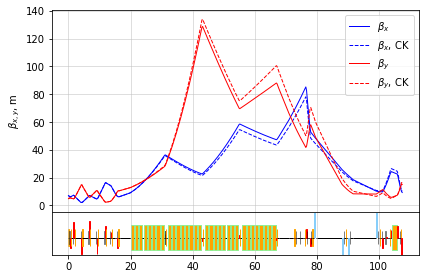

In [3]:
bx0 = [tw.beta_x for tw in tws1]
by0 = [tw.beta_y for tw in tws1]
s0 = [tw.s for tw in tws1]

bx = [tw.beta_x for tw in tws]
by = [tw.beta_y for tw in tws]
s = [tw.s for tw in tws]

fig, ax = plot_API(lat, legend=False)
ax.plot(s0, bx0, "b", lw=1, label=r"$\beta_x$")
ax.plot(s, bx, "b--", lw=1, label=r"$\beta_x$, CK")
ax.plot(s0, by0, "r", lw=1, label=r"$\beta_y$")
ax.plot(s, by, "r--", lw=1, label=r"$\beta_y$, CK")
ax.set_ylabel(r"$\beta_{x,y}$, m")
ax.legend()
plt.show()

#### Trajectories with Coupler Kick

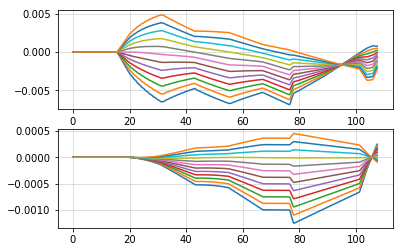

In [4]:
from ocelot.cpbd.track import lattice_track

for a in np.arange(-0.6, 0.6, 0.1):
    cix_118_i1.angle = a*0.001
    lat.update_transfer_maps()
    p = Particle(px=0, E=0.150-0.02)
    plist = lattice_track(lat, p)
    s = [p.s for p in plist]
    x = [p.x for p in plist]
    y = [p.y for p in plist]
    px = [p.px for p in plist]
    py = [p.py for p in plist]
    plt.subplot(211)
    plt.plot(s, x)
    plt.subplot(212)
    plt.plot(s, y)
plt.show()